In [314]:
import numpy as np
import pandas as pd
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [315]:
class Layers:
    def __init__(self,input_dim,output_dim,activation="sigmoid"): 
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.activation = activation
        self.W = np.random.randn(output_dim,input_dim) * 1
        self.b = np.zeros((output_dim,1))
        self.db = np.zeros((output_dim,1))
        self.H = None
        self.A = None
        self.dW = np.zeros((output_dim,input_dim))
        self.dH = None
    def activated_values(self,X):
        if self.activation == "sigmoid":
            A = np.clip(X, -700, 700)
            sig = 1 / (1 + np.exp(-A))
            return sig 
        if self.activation == "ReLU":
            relu = lambda x: x if x > 0 else 0
            return np.vectorize(relu)(X)
        if self.activation == "linear":
            return X 
        if self.activation == "Softmax":
            A = np.clip(X, -700, 700)  # Clipping to avoid overflow
            exps = np.exp(A - np.max(A, axis=0, keepdims=True))
            return exps / np.sum(exps, axis=0, keepdims=True)
        
    def dactivation_da(self,X):
        if self.activation == "sigmoid":
            A = np.clip(X, -500, 500)
            return 1/(1+np.exp(-A)) * (1 - 1/(1+np.exp(-A)))
        if self.activation == "ReLU":
            return np.where(X > 0, 1, 0)
        if self.activation == "linear":
            return np.ones_like(X)

class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers
        self.uW = []
        self.ub = []
        for layer in layers:
            self.uW.append(np.zeros((layer.dW.shape[0],layer.dW.shape[1])))
            self.ub.append(np.zeros((layer.db.shape[0],layer.db.shape[1])))
    
    def forward(self,X):
        # X = X.reshape(-1,1)
        self.layers[0].A = self.layers[0].W @ X + self.layers[0].b * np.ones((self.layers[0].b.shape[0],X.shape[1]))
        self.layers[0].H = self.layers[0].activated_values(self.layers[0].A)
        for i in range(1,len(self.layers)):
            self.layers[i].A = self.layers[i].W @ self.layers[i-1].H + self.layers[i].b
            self.layers[i].H = self.layers[i].activated_values(self.layers[i].A)
        return self.layers[i].H
    
    def backPropagation(self,X,Y):
        encoded_Y = np.zeros((Y.shape[0],10))
        encoded_Y[np.arange(Y.shape[0]),Y] = 1
        n = len(self.layers)
        for i in range(n):
            self.layers[i].dW = np.zeros_like(self.layers[i].dW) 
            self.layers[i].db = np.zeros_like(self.layers[i].db)
        for x, encoded_y in zip(X, encoded_Y):
            x = x.reshape(-1,1)
            encoded_y = encoded_y.reshape(-1,1)
            y_pred = self.forward(x)
            dL_da = - (encoded_y - y_pred)
            for i in range(n-1,0,-1):
                self.layers[i].dW = self.layers[i].dW + dL_da @(self.layers[i-1].H).T
                self.layers[i].db = self.layers[i].db + dL_da.reshape(-1,1)
                dL_dh = (self.layers[i].W).T @ dL_da
                dL_da = dL_dh * self.layers[i-1].dactivation_da(self.layers[i-1].A)
            self.layers[0].dW = self.layers[0].dW + dL_da @ (x.T)
            self.layers[0].db = self.layers[0].db + dL_da.reshape(-1,1)

    def update_step(self,X,Y,beta = 0,optimiser = "momentum"):
        if optimiser == "momentum":
            self.backPropagation(X,Y)
            for i in range(len(self.layers)):
                self.uW[i] = beta*self.uW[i] + self.layers[i].dW
                self.ub[i] = beta*self.ub[i] + self.layers[i].db
            
        if optimiser == "nesterov":
            weights,bias = [],[]
            for i in range(len(self.layers)):
                weights.append(self.layers[i].W.copy())
                bias.append(self.layers[i].b.copy())
                self.layers[i].W = self.layers[i].W - beta*self.uW[i]
                self.layers[i].b = self.layers[i].b - beta*self.ub[i]
            self.backPropagation(X,Y)
            for i in range(len(self.layers)):
                self.uW[i] = beta*self.uW[i] + self.layers[i].dW
                self.ub[i] = beta*self.ub[i] + self.layers[i].db
                self.layers[i].W = weights[i]
                self.layers[i].b = bias[i]

        if optimiser == "RMSprop":
            epsilon = 1e-8
            decay_rate = 0.9    
            self.backPropagation(X,Y)
            for i in range(len(self.layers)):
                self.uW[i] = decay_rate*self.uW[i] + (1-decay_rate)*self.layers[i].dW**2
                self.ub[i] = decay_rate*self.ub[i] + (1-decay_rate)*self.layers[i].db**2
                self.layers[i].W = self.layers[i].W - beta*self.layers[i].dW/(np.sqrt(self.uW[i])+epsilon)
                self.layers[i].b = self.layers[i].b - beta*self.layers[i].db/(np.sqrt(self.ub[i])+epsilon)

            weights,bias = [],[]
            for i in range(len(self.layers)):
                weights.append(self.layers[i].W.copy())
                bias.append(self.layers[i].b.copy())
                self.layers[i].W = self.layers[i].W - beta*self.uW[i]
                self.layers[i].b = self.layers[i].b - beta*self.ub[i]
            self.backPropagation(X,Y)
            for i in range(len(self.layers)):
                self.uW[i] = beta*self.uW[i] + self.layers[i].dW
                self.ub[i] = beta*self.ub[i] + self.layers[i].db
                self.layers[i].W = weights[i]
                self.layers[i].b = bias[i]

    def gradient_descent(self,X,Y,beta,eta,optimiser,gradientDescent="Vanilla"):
        
        if gradientDescent == "Vanilla":
            self.update_step(X,Y,beta=beta,optimiser = optimiser)
            for i in range(len(self.layers)):
                self.layers[i].W = self.layers[i].W - eta*(self.uW[i])/len(X)
                self.layers[i].b = self.layers[i].b - eta*(self.ub[i])/len(X)
                
        if gradientDescent == "Stochastic":
            for x, y in zip(X, Y):
                self.update_step(np.array([x]), np.array([y]), beta=beta, optimiser=optimiser)
                for i in range(len(self.layers)):
                    self.layers[i].W -= eta * self.uW[i]
                    self.layers[i].b -= eta * self.ub[i]
    
    def fit(self,X,y,beta,eta,epochs,optimiser,gradientDescent,verbose):
        for epoch in range(1,epochs+1):
            self.gradient_descent(X,y,beta=beta,eta=eta,optimiser = optimiser,gradientDescent = gradientDescent)
            if verbose:
                y_pred = self.forward(X.T).argmax(axis=0)
                accuracy = np.sum(y_pred==y)/len(y_pred)
                print(f"After epoch {epoch} the achieved accuracy is {accuracy}")

    def predict(self,X):
        return self.forward(X)


In [316]:
x*np.ones((z.shape[0],z.shape[1]))

array([[0., 0.],
       [1., 1.],
       [2., 2.],
       [3., 3.],
       [4., 4.],
       [5., 5.],
       [6., 6.],
       [7., 7.],
       [8., 8.],
       [9., 9.]])

In [317]:
z = np.arange(20).reshape(-1,2)
x = np.arange(10).reshape(-1,1)
z+x

array([[ 0,  1],
       [ 3,  4],
       [ 6,  7],
       [ 9, 10],
       [12, 13],
       [15, 16],
       [18, 19],
       [21, 22],
       [24, 25],
       [27, 28]])

In [318]:
fashion_mnist_data = fashion_mnist.load_data()
train_data_x,train_data_y, test_data_x, test_data_y = fashion_mnist_data[0][0], fashion_mnist_data[0][1], fashion_mnist_data[1][0], fashion_mnist_data[1][1]
train_data_x = train_data_x.reshape(train_data_x.shape[0],-1)
test_data_x = test_data_x.reshape(test_data_x.shape[0],-1)
train_data_x, validation_data_x, train_data_y, validation_data_y = train_test_split(train_data_x, train_data_y, test_size=0.1)
train_data_x = train_data_x / 255.0
validation_data_x = validation_data_x / 255.0
test_data_x = test_data_x / 255.0
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [319]:
(train_data_x.reshape(train_data_x.shape[0],-1)).shape

(54000, 784)

In [320]:
model = NeuralNetwork([
    Layers(784,100),
    Layers(100,50),
    Layers(50,10,activation="Softmax"),
])

In [326]:
model.fit(X=train_data_x,y=train_data_y,beta=1,eta=1,epochs=10,optimiser="momemtum",gradientDescent="Vanilla",verbose=True)

After epoch 1 the achieved accuracy is 0.08044444444444444
After epoch 2 the achieved accuracy is 0.08044444444444444
After epoch 3 the achieved accuracy is 0.08044444444444444
After epoch 4 the achieved accuracy is 0.08044444444444444
After epoch 5 the achieved accuracy is 0.08044444444444444
After epoch 6 the achieved accuracy is 0.08044444444444444
After epoch 7 the achieved accuracy is 0.08044444444444444
After epoch 8 the achieved accuracy is 0.08044444444444444
After epoch 9 the achieved accuracy is 0.08044444444444444
After epoch 10 the achieved accuracy is 0.08044444444444444


In [322]:
train_data_x.shape

(54000, 784)

In [323]:
model.layers[0].W.shape

(100, 784)

TypeError: Invalid shape (784,) for image data

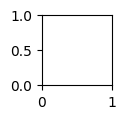

In [324]:
class_id,images_index_each_class = np.unique(train_data_y, return_index=True)
plt.figure(figsize=(2,7))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.imshow(train_data_x[images_index_each_class[i]])
    plt.title(class_names[class_id[i]])
    plt.axis('off')
plt.show()

In [ ]:
y_pred = model.predict(validation_data_x)
y_true = validation_data_y
accuracy = np.sum(y_pred==y_true)/len(y_pred)
accuracy

0.6618333333333334

In [ ]:
train_data_y.shape
encoded_y = np.zeros((train_data_y.shape[0],np.max(train_data_y)+1))
encoded_y[np.arange(train_data_y.shape[0]),train_data_y] = 1


In [ ]:
encoded_y[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])